# Consumer

## Imports

In [1]:
import json
import pylab as pl
import numpy as np

from IPython import display

from kafka import KafkaConsumer
from kafka.admin import KafkaAdminClient

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import json
import pylab as pl
import numpy as np

## Input

In [2]:
#KAFKA_HOME = '/root/kafka_2.13-3.2.1'
# kafka server
KAFKA_BOOTSTRAP_SERVERS = ['pd-slave3:9092',]

# definition of the consumer
consumer = KafkaConsumer(bootstrap_servers=KAFKA_BOOTSTRAP_SERVERS, consumer_timeout_ms=100000)
consumer.topics()

{'topic_results', 'topic_stream'}

In [3]:
consumer.subscribe('topic_results')
consumer.subscription()

{'topic_results'}

In [4]:
# print the list of partition IDs 
# e.g. a topic with tree partitions will have partition IDs {0, 1, 2}
consumer.partitions_for_topic('topic_results')

{0}

### Histogram Plotting

In [63]:
def set_axes( ax ):
    ax[0,0].set_xlim([ 0,  63])
    ax[0,1].set_xlim([64, 127])
    ax[0,2].set_xlim([ 0,  63])
    ax[0,3].set_xlim([64, 127])
    ax[0,0].set_ylim([ 0, 100])
    ax[0,1].set_ylim([ 0, 100])
    ax[0,2].set_ylim([ 0, 100])
    ax[0,3].set_ylim([ 0, 100])

    ax[1,0].set_xlim([0,  15])
    ax[1,1].set_xlim([0,  15])
    ax[1,2].set_xlim([0,  15])
    ax[1,3].set_xlim([0,  15])
    ax[1,0].set_ylim([0, 750])
    ax[1,1].set_ylim([0, 750])
    ax[1,2].set_ylim([0, 750])
    ax[1,3].set_ylim([0, 750])

    ax[2,0].set_xlim([ 0, 63])
    ax[2,1].set_xlim([64,127])
    ax[2,2].set_xlim([ 0, 63])
    ax[2,3].set_xlim([64,127])
    ax[2,0].set_ylim([0,   3])
    ax[2,1].set_ylim([0,   3])
    ax[2,2].set_ylim([0,   3])
    ax[2,3].set_ylim([0,   3])


def hist_sum( histo_prev, histo_new ):
    '''
    Function to update the histogram with the new values,
    obtaining the cumulative values.
    Inputs:
        histo_prev: message with the previous sum
        histo_new: message with the new values
    Output:
        message with the updated values
    '''
    histo_prev[    'time'] += histo_new[    'time']
    histo_prev['epoch_id']  = histo_new['epoch_id']
    histo_prev[    'hits'] += histo_new[    'hits']
    
    for chamber in ['CH0','CH1','CH2','CH3']:
        histo_prev[chamber]['total_hits'] += histo_new[chamber]['total_hits']
        for feature in ['histo_CH', 'histo_ORB', 'histo_SC']:
            print(chamber, feature)
            new_edges = np.array(list(map(int, histo_new[chamber][feature]['bin_edges'])))
            if chamber in ['CH1', 'CH3']:
                new_edges -= 64
            histo_prev[chamber][feature][ 'bin_counts'][new_edges] += histo_new[chamber][feature]['bin_counts']
    return histo_prev


def build_hist( msg, fig, axes, set_lims=True ):
    '''
    Function to build up the histograms in the 
    live dashboard.
    Inputs:
        - msg: message content
        - fig: matplotlib figure
        - axes: list of axes of the figure
        - set_lims: bool, true if single batch histograms are plotted
    '''
    labels     = [ 'TDC_CHANNEL', 'ORBIT_CNT', 'TDC_CHANNEL' ]
    histograms = [    'histo_CH', 'histo_ORB',    'histo_SC' ]
    
    for i, AX in enumerate(axes): # loop over chambers
        histo = histograms[i]

        for j, ax in enumerate(AX): # loop over histograms
            chamber = 'CH'+str(j)
            ax.clear()
            ax.grid(ls='dotted')
            ax.set_title( chamber )
            ax.set_xlabel(labels[i])
            ax.bar( list(map(int, msg[chamber][histo][ 'bin_edges'])),
                                  msg[chamber][histo]['bin_counts'] )
            ax.tick_params()
            
    set_axes(axes)
    display.clear_output(wait=True)
    display.display(pl.gcf())


KeyboardInterrupt



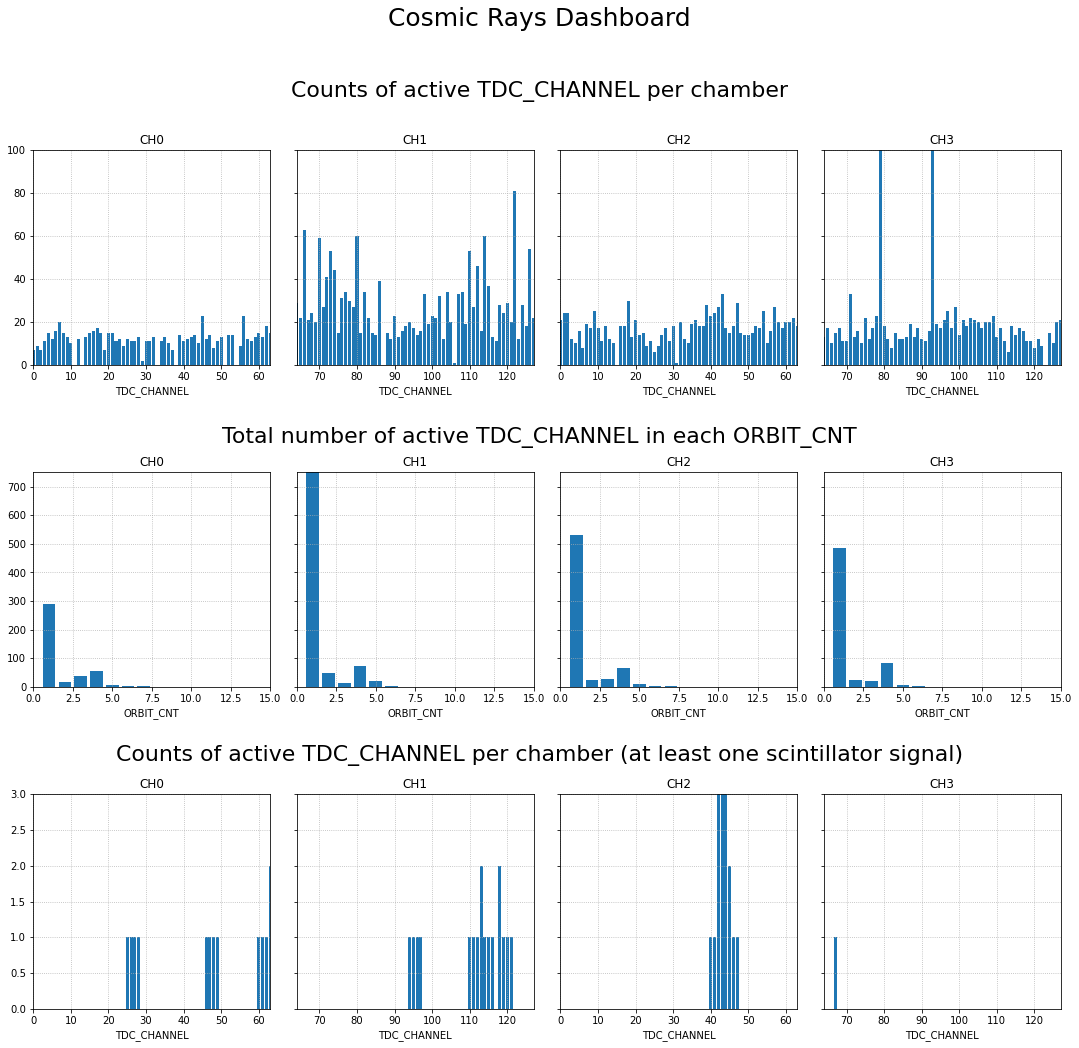

In [64]:
fig, ax = plt.subplots(nrows=3, ncols=4, sharey='row', figsize=(15,13))

fig.suptitle('Cosmic Rays Dashboard', fontsize=25, y=1.1)
fig.tight_layout()
fig.subplots_adjust(hspace=.5)

plt.figtext(0.5, 1.01, 'Counts of active TDC_CHANNEL per chamber', ha='center', va='center', fontsize = 22)
plt.figtext(0.5,  .64, 'Total number of active TDC_CHANNEL in each ORBIT_CNT', ha='center', va='center', fontsize = 22)
plt.figtext(0.5,  .30, 'Counts of active TDC_CHANNEL per chamber (at least one scintillator signal)', ha='center', va='center', fontsize = 22)

for msg in consumer:
    
    msg_json = json.loads(msg.value)
    
    print("Number of hits: ", msg_json['hits'])
    for chamber in range(4):
        print(f"Number of hits - CHAMBER {chamber}:\t", msg_json['CH'+str(chamber)]['total_hits'])
    
    build_hist(msg_json, fig, ax)

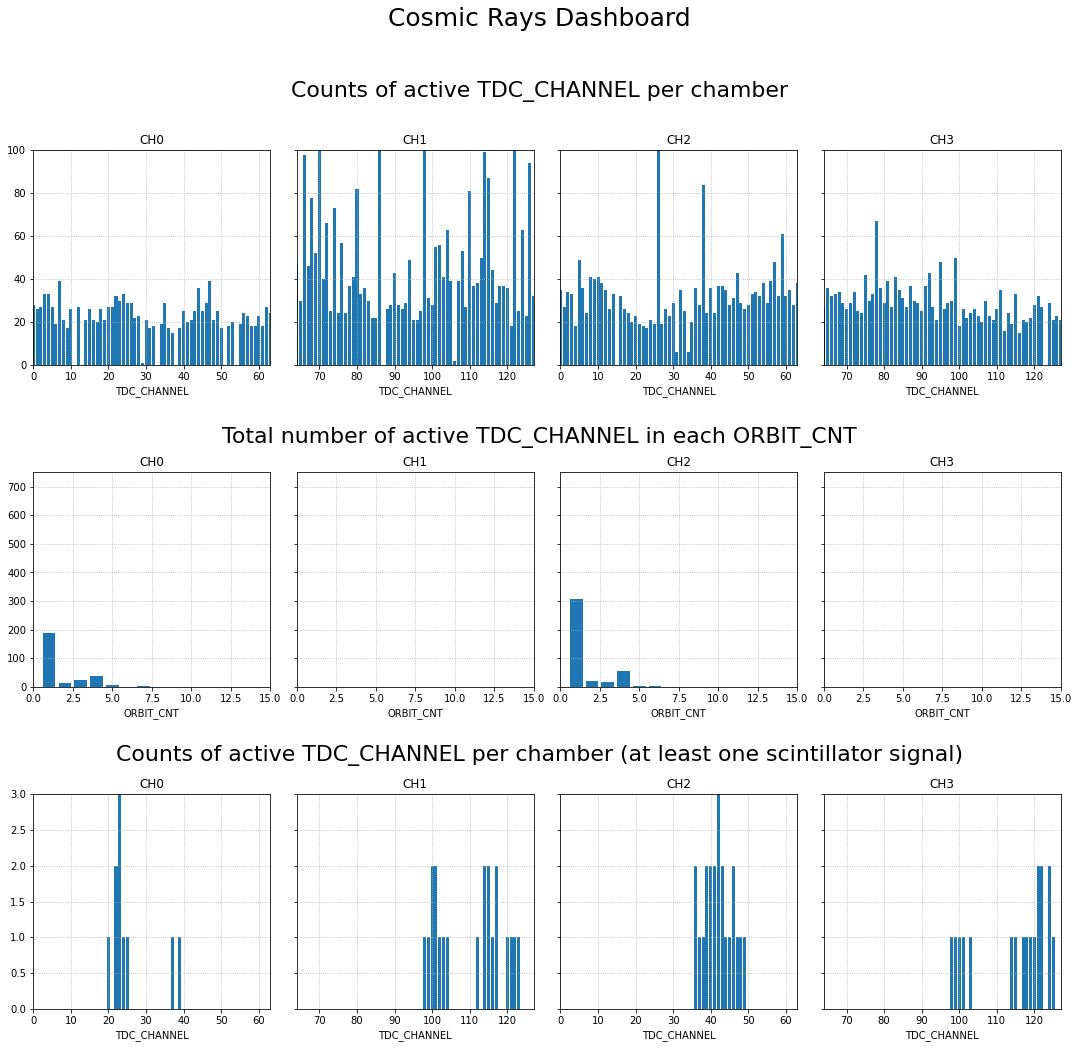

CH0 histo_CH


IndexError: index 69 is out of bounds for axis 0 with size 64

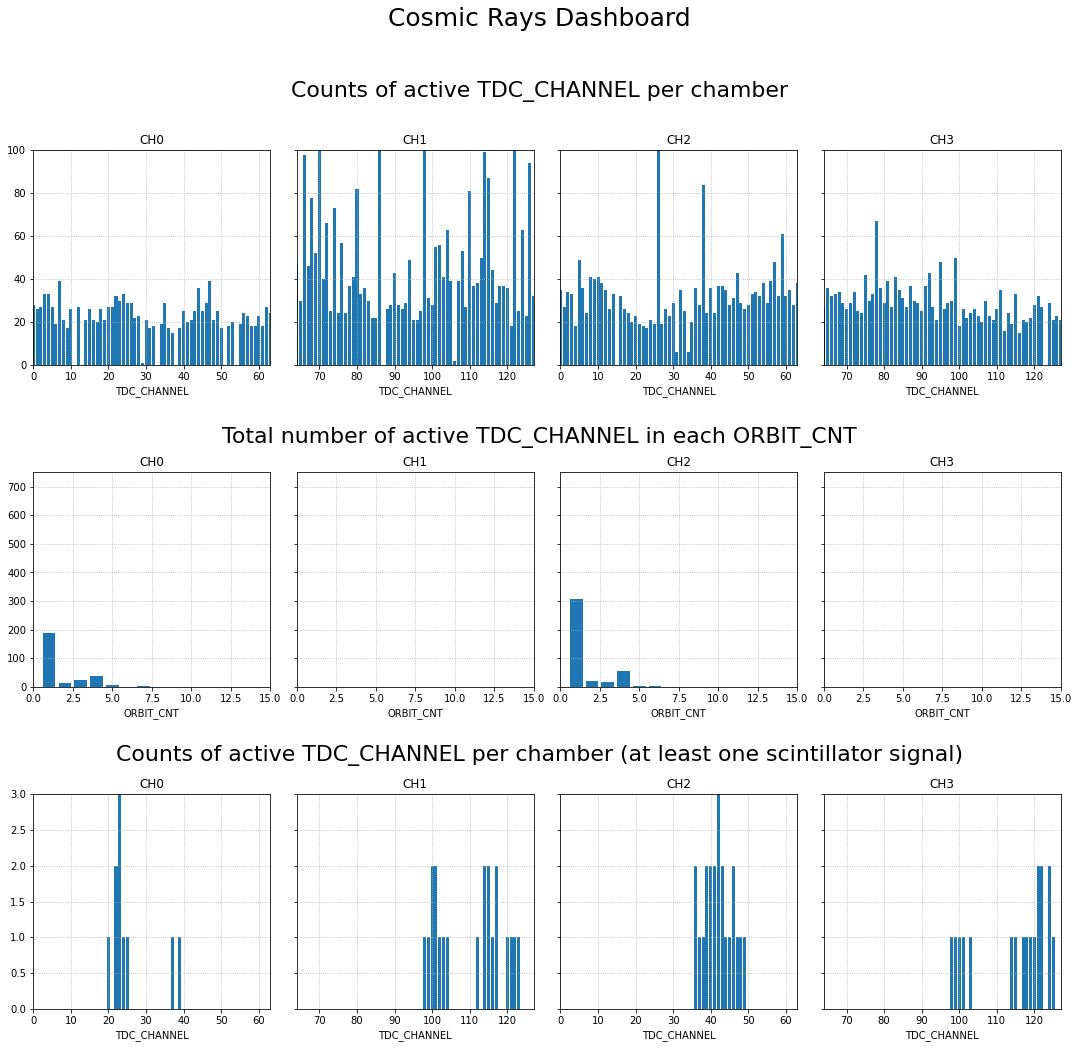

In [66]:
fig, ax = plt.subplots(nrows=3, ncols=4, sharey='row', figsize=(15,13))

fig.suptitle('Cosmic Rays Dashboard', fontsize=25, y=1.1)
fig.tight_layout()
fig.subplots_adjust(hspace=.5)

plt.figtext(0.5, 1.01, 'Counts of active TDC_CHANNEL per chamber', ha='center', va='center', fontsize = 22)
plt.figtext(0.5,  .64, 'Total number of active TDC_CHANNEL in each ORBIT_CNT', ha='center', va='center', fontsize = 22)
plt.figtext(0.5,  .30, 'Counts of active TDC_CHANNEL per chamber (at least one scintillator signal)', ha='center', va='center', fontsize = 22)  

for i, msg in enumerate(consumer):
    if i == 0:
        msg_json = json.loads(msg.value)

        for chamber in ['CH0','CH2']:
            for feature in ['histo_CH', 'histo_SC']:
                edges  = np.arange(64)
                counts = np.zeros(shape=64, dtype=int)
                new_edges = np.array(list(map(int, msg_json[chamber][feature]['bin_edges'])))
                counts[new_edges] += msg_json[chamber][feature]['bin_counts']
                msg_json[chamber][feature][ 'bin_edges']         =  edges
                msg_json[chamber][feature]['bin_counts']         = counts

        for chamber in ['CH1','CH3']:
            for feature in ['histo_CH', 'histo_SC']:
                edges  = np.arange(64, 128)
                counts = np.zeros(shape=64, dtype=int)
                new_edges = np.array(list(map(int, msg_json[chamber][feature]['bin_edges'])))-64
                
                counts[new_edges] += msg_json[chamber][feature]['bin_counts']
                msg_json[chamber][feature][ 'bin_edges']            =  edges
                msg_json[chamber][feature]['bin_counts']            = counts

                
        for chamber in ['CH0','CH1','CH2','CH3']:
                edges  = np.arange(0, 100)
                counts = np.zeros(shape=100, dtype=int)
                new_edges = np.array(list(map(int, msg_json[chamber]['histo_ORB']['bin_edges'])))-64
                
                counts[new_edges] += msg_json[chamber]['histo_ORB']['bin_counts']
                msg_json[chamber]['histo_ORB'][ 'bin_edges']            =  edges
                msg_json[chamber]['histo_ORB']['bin_counts']            = counts

            
    else:
        msg_json = hist_sum(msg_json, json.loads(msg.value))
    print("Number of hits: ", msg_json['hits'])
    for chamber in range(4):
        print(f"Number of hits - CHAMBER {chamber}:\t", msg_json['CH'+str(chamber)]['total_hits'])
    
    build_hist(msg_json, fig, ax, False)

In [71]:
for msg in consumer:
    mj=json.loads(msg.value)
    print(mj['CH0']['histo_CH']['bin_edges'])

KeyboardInterrupt: 

In [69]:
a

NameError: name 'a' is not defined